# Multivariate Analysis and Leverage Points

**Date:** 2 October 2024

**Topic:** Advanced multivariate statistical analysis with leverage point detection

This notebook covers:
1. Covariance and Correlation Matrix Analysis
2. Hat Matrix and Leverage Point Calculation
3. Outlier Detection in Multivariate Settings
4. Real-world Dataset Applications
5. Influence Diagnostics

## 1. Setup and Dependencies

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

## 2. Synthetic Dataset Generation

### 2.1 Creating Multivariate Housing Dataset

In [3]:
# Generate synthetic housing dataset with multivariate structure
n = 500

# Generate correlated features
MedInc = np.random.lognormal(mean=2.5, sigma=0.35, size=n)
HouseAge = np.random.randint(1, 52, size=n)
Longitude = -125.4 + np.random.rand(n) * 10
Latitude = 32 + np.random.rand(n) * 8

# Create dependent variable with known relationships
AveRooms = 5 + 0.15 * MedInc + 0.03 * HouseAge + np.random.rand(n)

# Target variable with multiple dependencies
target = (
    0.45 * MedInc
    - 0.02 * HouseAge
    - 0.3 * (Latitude - 36)
    - 0.1 * (Longitude + 119)
    + np.random.rand(n) * 0.5
)

# Create DataFrame
df = pd.DataFrame({
    "MedInc": MedInc,
    "House_Age": HouseAge,
    "Longitude": Longitude,
    "Latitude": Latitude,
    "AveRooms": AveRooms,
    "Target": target
})

print("Synthetic Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Features: {list(df.columns[:-1])}")
print(f"Target: {df.columns[-1]}")
print("\nFirst few rows:")
display(df.head())

Synthetic Dataset Information:
Shape: (500, 6)
Features: ['MedInc', 'House_Age', 'Longitude', 'Latitude', 'AveRooms']
Target: Target

First few rows:


,MedInc,House_Age,Longitude,Latitude,AveRooms,Target
0,14.495670,26,-115.906932,38.019422,8.119645,5.443360
1,11.606990,34,-121.433506,32.723854,8.461300,6.222811
2,15.282234,45,-115.859131,34.309485,9.228145,6.236259
3,20.760672,6,-124.049987,32.872877,8.880580,10.961945
4,11.223910,37,-120.562451,37.204093,8.491257,4.405337


### 2.2 Basic Statistical Summary

In [4]:
# Display descriptive statistics
print("Descriptive Statistics:")
print("=" * 60)
display(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Data types
print("\nData Types:")
print(df.dtypes)

Descriptive Statistics:


,MedInc,House_Age,Longitude,Latitude,AveRooms,Target
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,12.969860,26.150000,-120.360983,35.936224,8.224311,5.725582
std,4.792398,14.909866,2.940040,2.242943,0.857942,2.276504
min,3.917902,1.000000,-125.397625,32.002660,6.173638,1.390582
25%,9.534268,12.000000,-122.930237,33.906047,7.637924,4.275493
50%,12.237182,27.000000,-120.187195,36.012813,8.164385,5.408000
75%,15.224038,38.000000,-117.897041,37.903054,8.712994,6.907709
max,46.920563,51.000000,-115.406465,39.963844,12.558465,22.907620



Missing Values:
MedInc       0
House_Age    0
Longitude    0
Latitude     0
AveRooms     0
Target       0
dtype: int64

Data Types:
MedInc       float64
House_Age      int64
Longitude    float64
Latitude     float64
AveRooms     float64
Target       float64
dtype: object


## 3. Covariance and Correlation Analysis

### 3.1 Covariance Matrix

In [5]:
# Calculate covariance and correlation matrices
numeric_cols = df.columns.tolist()
cov_mat = df[numeric_cols].cov()
corr_mat = df[numeric_cols].corr()

print("Covariance Matrix:")
print("=" * 50)
display(cov_mat.round(3))

print("\nCorrelation Matrix:")
print("=" * 50)
display(corr_mat.round(3))

Covariance Matrix:


,MedInc,House_Age,Longitude,Latitude,AveRooms,Target
MedInc,22.967,-3.196,0.114,0.694,3.249,10.192
House_Age,-3.196,222.304,-2.162,-0.080,6.056,-5.813
Longitude,0.114,-2.162,8.644,0.390,-0.037,-0.867
Latitude,0.694,-0.080,0.390,5.031,0.112,-1.225
AveRooms,3.249,6.056,-0.037,0.112,0.736,1.307
Target,10.192,-5.813,-0.867,-1.225,1.307,5.182



Correlation Matrix:


,MedInc,House_Age,Longitude,Latitude,AveRooms,Target
MedInc,1.000,-0.045,0.008,0.065,0.790,0.934
House_Age,-0.045,1.000,-0.049,-0.002,0.473,-0.171
Longitude,0.008,-0.049,1.000,0.059,-0.015,-0.130
Latitude,0.065,-0.002,0.059,1.000,0.058,-0.240
AveRooms,0.790,0.473,-0.015,0.058,1.000,0.669
Target,0.934,-0.171,-0.130,-0.240,0.669,1.000


### 3.2 Correlation Heatmap Visualization

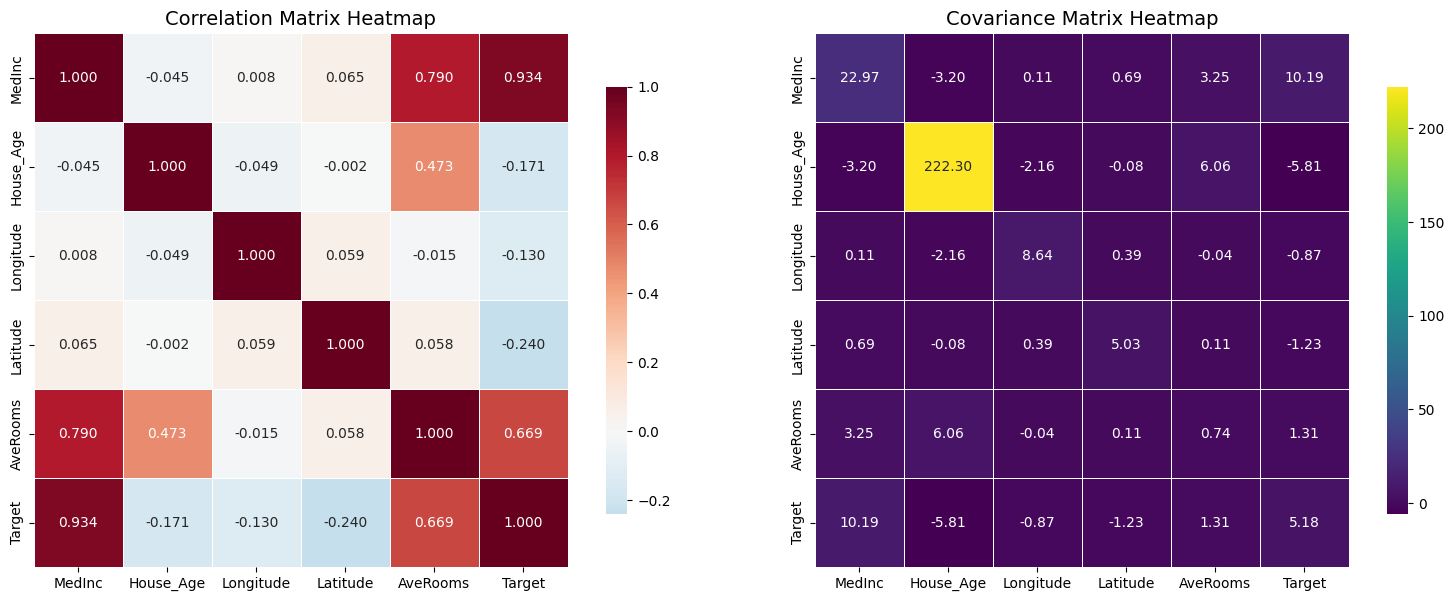


Strongest correlations with Target:
MedInc      :  0.934
AveRooms    :  0.669
Latitude    : -0.240
House_Age   : -0.171
Longitude   : -0.130


In [6]:
# Create comprehensive correlation visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
sns.heatmap(
    corr_mat, 
    annot=True, 
    cmap='RdBu_r', 
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    fmt='.3f',
    ax=ax1
)
ax1.set_title('Correlation Matrix Heatmap', fontsize=14)

# Covariance heatmap
sns.heatmap(
    cov_mat, 
    annot=True, 
    cmap='viridis', 
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    fmt='.2f',
    ax=ax2
)
ax2.set_title('Covariance Matrix Heatmap', fontsize=14)

plt.tight_layout()
plt.show()

# Identify strongest correlations with target
target_corr = corr_mat['Target'].drop('Target').sort_values(key=abs, ascending=False)
print("\nStrongest correlations with Target:")
for feature, corr in target_corr.items():
    print(f"{feature:12}: {corr:6.3f}")

## 4. Hat Matrix and Leverage Analysis

### 4.1 Hat Matrix Calculation

In [7]:
# Prepare data for leverage analysis
y = df["Target"].values.reshape(-1, 1)
X = df[["MedInc", "House_Age", "Longitude", "Latitude", "AveRooms"]].values

print(f"Matrix dimensions:")
print(f"X (design matrix): {X.shape}")
print(f"y (target vector): {y.shape}")

# Calculate Hat matrix components
XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
beta = XtX_inv @ X.T @ y
y_hat = X @ beta
resid = y - y_hat

# Hat Matrix H = X(X'X)^(-1)X'
H = X @ XtX_inv @ X.T
leverage = np.diag(H)

print(f"\nHat matrix shape: {H.shape}")
print(f"Leverage values shape: {leverage.shape}")
print(f"\nLeverage statistics:")
print(f"Mean: {np.mean(leverage):.6f}")
print(f"Std:  {np.std(leverage):.6f}")
print(f"Min:  {np.min(leverage):.6f}")
print(f"Max:  {np.max(leverage):.6f}")

Matrix dimensions:
X (design matrix): (500, 5)
y (target vector): (500, 1)

Hat matrix shape: (500, 500)
Leverage values shape: (500,)

Leverage statistics:
Mean: 0.010000
Std:  0.006765
Min:  0.002319
Max:  0.114794


### 4.2 Leverage Thresholds and Identification

In [8]:
# Calculate leverage thresholds
n, p = X.shape
avg_leverage = p / n
threshold_2p = 2 * avg_leverage
threshold_3p = 3 * avg_leverage

print(f"Leverage Analysis:")
print(f"Sample size (n): {n}")
print(f"Number of parameters (p): {p}")
print(f"Average leverage (p/n): {avg_leverage:.6f}")
print(f"Threshold 2p/n: {threshold_2p:.6f}")
print(f"Threshold 3p/n: {threshold_3p:.6f}")

# Identify high leverage points
high_leverage_2p = np.where(leverage > threshold_2p)[0]
high_leverage_3p = np.where(leverage > threshold_3p)[0]

print(f"\nHigh leverage points:")
print(f"Points above 2p/n threshold: {len(high_leverage_2p)}")
print(f"Points above 3p/n threshold: {len(high_leverage_3p)}")
print(f"Percentage above 2p/n: {len(high_leverage_2p)/n*100:.2f}%")
print(f"Percentage above 3p/n: {len(high_leverage_3p)/n*100:.2f}%")

Leverage Analysis:
Sample size (n): 500
Number of parameters (p): 5
Average leverage (p/n): 0.010000
Threshold 2p/n: 0.020000
Threshold 3p/n: 0.030000

High leverage points:
Points above 2p/n threshold: 15
Points above 3p/n threshold: 3
Percentage above 2p/n: 3.00%
Percentage above 3p/n: 0.60%


### 4.3 Leverage Analysis Summary Table

In [9]:
# Create comprehensive summary DataFrame
summary = pd.DataFrame({
    "index": np.arange(n),
    "leverage": leverage,
    "y_actual": y.flatten(),
    "y_predicted": y_hat.flatten(),
    "residual": resid.flatten()
})

# Add leverage categories
summary['leverage_category'] = 'Normal'
summary.loc[summary['leverage'] > threshold_2p, 'leverage_category'] = 'High (2p/n)'
summary.loc[summary['leverage'] > threshold_3p, 'leverage_category'] = 'Very High (3p/n)'

print("Top 10 Leverage Points:")
print("=" * 80)
top_leverage = summary.sort_values(by="leverage", ascending=False).head(10)
display(top_leverage[['index', 'leverage', 'leverage_category', 'y_actual', 'y_predicted', 'residual']].round(4))

# Leverage distribution
print("\nLeverage Point Distribution:")
print(summary['leverage_category'].value_counts())

Top 10 Leverage Points:


,index,leverage,leverage_category,y_actual,y_predicted,residual
209,209,0.1148,Very High (3p/n),22.9076,22.7670,0.1406
478,478,0.0517,Very High (3p/n),16.4008,16.3177,0.0831
179,179,0.0338,Very High (3p/n),14.3956,14.2114,0.1843
234,234,0.0281,High (2p/n),9.8288,9.8176,0.0112
220,220,0.0277,High (2p/n),11.8508,11.7401,0.1107
113,113,0.0276,High (2p/n),12.3773,12.2856,0.0918
323,323,0.0244,High (2p/n),9.7744,9.8030,-0.0287
31,31,0.0242,High (2p/n),9.6602,9.7258,-0.0655
284,284,0.0241,High (2p/n),11.0901,10.9538,0.1363
252,252,0.0237,High (2p/n),11.7144,11.5805,0.1339



Leverage Point Distribution:
leverage_category
Normal              485
High (2p/n)          12
Very High (3p/n)      3
Name: count, dtype: int64


### 4.4 Leverage Visualization

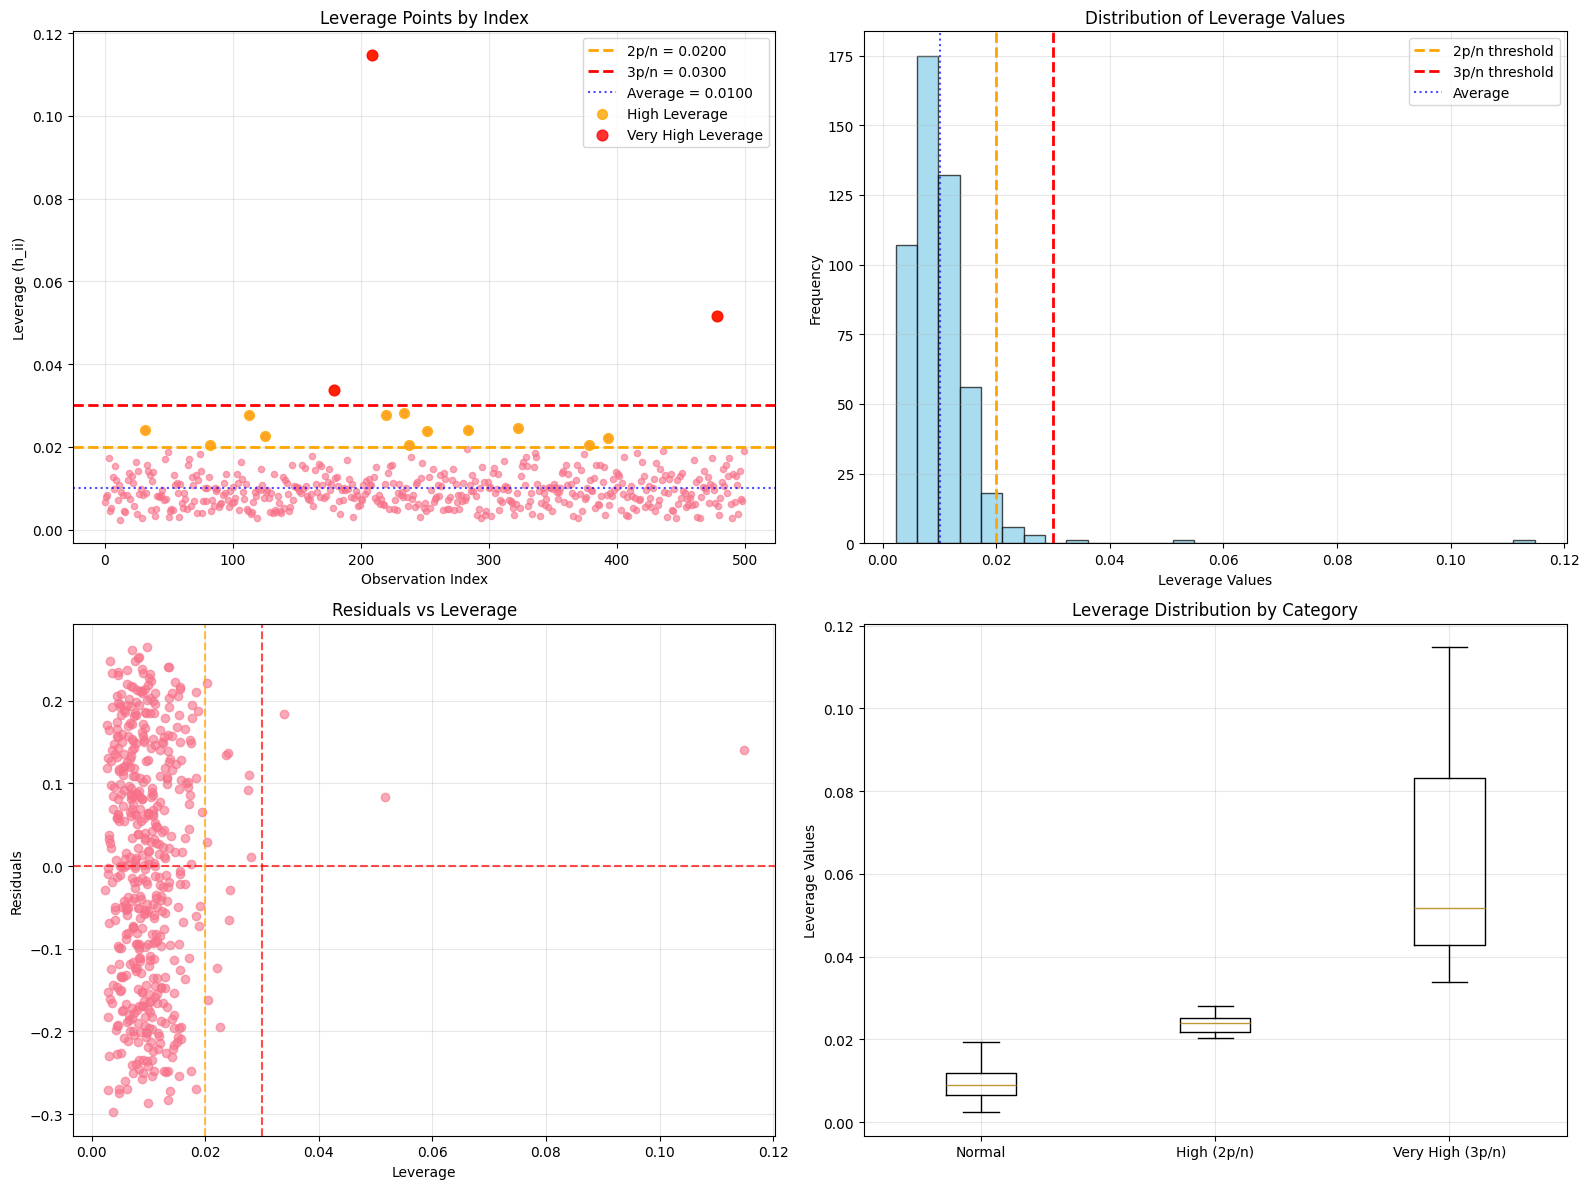

In [10]:
# Create comprehensive leverage plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Leverage values by index
ax1.scatter(summary["index"], summary["leverage"], s=20, alpha=0.6)
ax1.axhline(threshold_2p, color='orange', linestyle='--', linewidth=2, label=f'2p/n = {threshold_2p:.4f}')
ax1.axhline(threshold_3p, color='red', linestyle='--', linewidth=2, label=f'3p/n = {threshold_3p:.4f}')
ax1.axhline(avg_leverage, color='blue', linestyle=':', alpha=0.7, label=f'Average = {avg_leverage:.4f}')

# Highlight high leverage points
if len(high_leverage_2p) > 0:
    ax1.scatter(high_leverage_2p, summary.loc[high_leverage_2p, "leverage"], 
               s=50, color='orange', alpha=0.8, label='High Leverage')
if len(high_leverage_3p) > 0:
    ax1.scatter(high_leverage_3p, summary.loc[high_leverage_3p, "leverage"], 
               s=60, color='red', alpha=0.8, label='Very High Leverage')

ax1.set_xlabel('Observation Index')
ax1.set_ylabel('Leverage (h_ii)')
ax1.set_title('Leverage Points by Index')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram of leverage values
ax2.hist(leverage, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(threshold_2p, color='orange', linestyle='--', linewidth=2, label=f'2p/n threshold')
ax2.axvline(threshold_3p, color='red', linestyle='--', linewidth=2, label=f'3p/n threshold')
ax2.axvline(avg_leverage, color='blue', linestyle=':', alpha=0.7, label=f'Average')
ax2.set_xlabel('Leverage Values')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Leverage Values')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals vs Leverage
ax3.scatter(leverage, resid.flatten(), alpha=0.6)
ax3.axhline(0, color='red', linestyle='--', alpha=0.7)
ax3.axvline(threshold_2p, color='orange', linestyle='--', alpha=0.7)
ax3.axvline(threshold_3p, color='red', linestyle='--', alpha=0.7)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Residuals')
ax3.set_title('Residuals vs Leverage')
ax3.grid(True, alpha=0.3)

# Plot 4: Box plot of leverage by category
leverage_data = [summary[summary['leverage_category'] == cat]['leverage'].values 
                for cat in summary['leverage_category'].unique()]
ax4.boxplot(leverage_data, labels=summary['leverage_category'].unique())
ax4.set_ylabel('Leverage Values')
ax4.set_title('Leverage Distribution by Category')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Real-world Example: Housing Market Analysis

### 5.1 Simulated Housing Dataset with Outliers

In [11]:
# Create realistic housing dataset with known outliers
np.random.seed(0)

# Normal houses
n_normal = 100
house_size = np.random.normal(2000, 400, n_normal)
house_price = 100 + 0.05 * house_size + np.random.normal(0, 20, n_normal)

# Add luxury mansions (outliers)
mansion_sizes = np.array([5000, 6000, 7000])
mansion_prices = np.array([450, 550, 800])

# Combine data
all_sizes = np.append(house_size, mansion_sizes)
all_prices = np.append(house_price, mansion_prices)

print(f"Housing Dataset:")
print(f"Total properties: {len(all_sizes)}")
print(f"Normal houses: {n_normal}")
print(f"Luxury mansions: {len(mansion_sizes)}")

# Fit regression model using statsmodels
X_housing = sm.add_constant(all_sizes)
model_housing = sm.OLS(all_prices, X_housing).fit()

print(f"\nRegression Results:")
print(f"Intercept: {model_housing.params[0]:.2f}")
print(f"Slope: {model_housing.params[1]:.4f}")
print(f"R-squared: {model_housing.rsquared:.4f}")

Housing Dataset:
Total properties: 103
Normal houses: 100
Luxury mansions: 3

Regression Results:
Intercept: 19.55
Slope: 0.0911
R-squared: 0.8639


### 5.2 Housing Data Visualization

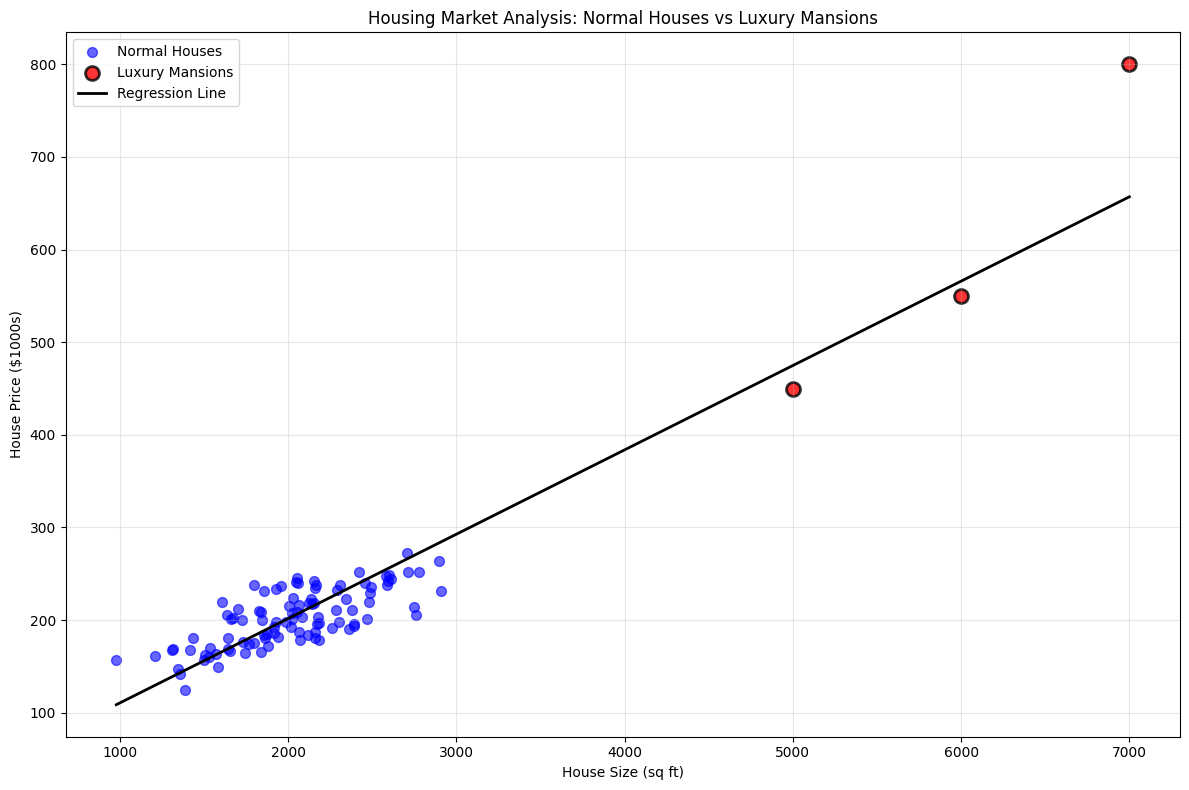


Detailed Model Summary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5523      8.203      2.383      0.019       3.279      35.825
x1             0.0911      0.004     25.320      0.000       0.084       0.098


In [12]:
# Visualize housing data with regression line
plt.figure(figsize=(12, 8))

# Plot normal houses
plt.scatter(house_size, house_price, label='Normal Houses', 
           color="blue", alpha=0.6, s=50)

# Plot mansions (outliers)
plt.scatter(mansion_sizes, mansion_prices, label='Luxury Mansions', 
           color="red", s=100, alpha=0.8, edgecolor='black', linewidth=2)

# Add regression line
x_range = np.linspace(all_sizes.min(), all_sizes.max(), 100)
y_pred_line = model_housing.params[0] + model_housing.params[1] * x_range
plt.plot(x_range, y_pred_line, color='black', linewidth=2, label='Regression Line')

plt.xlabel('House Size (sq ft)')
plt.ylabel('House Price ($1000s)')
plt.title('Housing Market Analysis: Normal Houses vs Luxury Mansions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display model summary
print("\nDetailed Model Summary:")
print(model_housing.summary().tables[1])

### 5.3 Leverage Analysis for Housing Data

In [13]:
# Get leverage and influence measures
influence_housing = model_housing.get_influence()
leverage_housing = influence_housing.hat_matrix_diag
residuals_housing = model_housing.resid

# Calculate thresholds for housing data
n_houses = len(all_sizes)
p_houses = X_housing.shape[1]  # includes intercept
avg_lev_houses = p_houses / n_houses
threshold_houses = 2 * avg_lev_houses

print(f"Housing Data Leverage Analysis:")
print(f"Sample size: {n_houses}")
print(f"Parameters: {p_houses}")
print(f"Average leverage: {avg_lev_houses:.6f}")
print(f"Threshold (2p/n): {threshold_houses:.6f}")

# Identify high leverage points
high_leverage_houses = np.where(leverage_housing > threshold_houses)[0]
print(f"\nHigh leverage points: {len(high_leverage_houses)}")
print(f"High leverage indices: {high_leverage_houses}")
print(f"High leverage values: {leverage_housing[high_leverage_houses]:.6f}" if len(high_leverage_houses) == 1 else f"High leverage values: {leverage_housing[high_leverage_houses]}")

# Check if mansions are high leverage
mansion_indices = list(range(n_normal, n_normal + len(mansion_sizes)))
print(f"\nMansion indices: {mansion_indices}")
print(f"Mansion leverage values: {leverage_housing[mansion_indices]}")
print(f"Are mansions high leverage? {all(idx in high_leverage_houses for idx in mansion_indices)}")

Housing Data Leverage Analysis:
Sample size: 103
Parameters: 2
Average leverage: 0.019417
Threshold (2p/n): 0.038835

High leverage points: 3
High leverage indices: [100 101 102]
High leverage values: [0.13694378 0.24146323 0.37708716]

Mansion indices: [100, 101, 102]
Mansion leverage values: [0.13694378 0.24146323 0.37708716]
Are mansions high leverage? True


### 5.4 Leverage vs Residuals Analysis

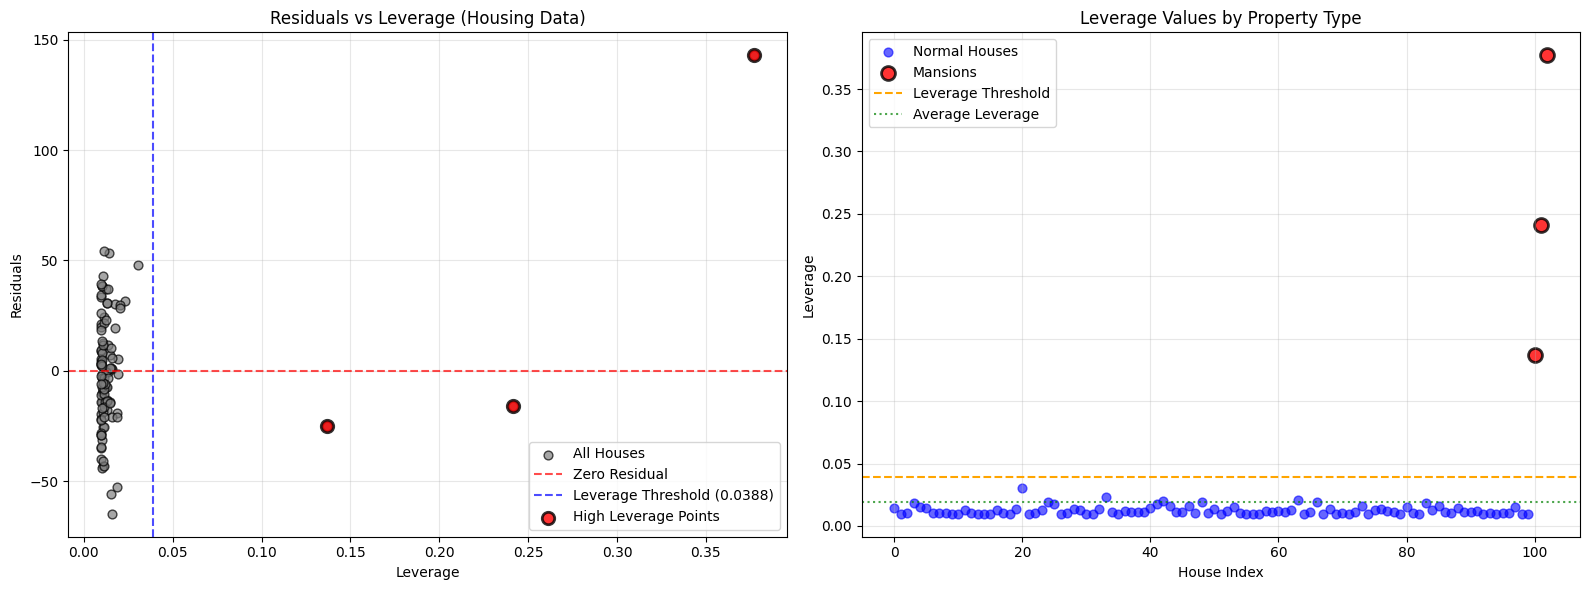


Leverage Summary:
Normal houses - Mean: 0.012445, Max: 0.030669
Mansions - Mean: 0.251831, Max: 0.377087
Ratio (mansion/normal): 20.24


In [14]:
# Create detailed leverage diagnostic plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Leverage vs Residuals
ax1.scatter(leverage_housing, residuals_housing, alpha=0.7, color='gray', 
           edgecolor='black', s=40, label='All Houses')
ax1.axhline(0, color='red', linestyle='--', alpha=0.7, label='Zero Residual')
ax1.axvline(threshold_houses, color='blue', linestyle='--', alpha=0.7, 
           label=f'Leverage Threshold ({threshold_houses:.4f})')

# Highlight high leverage points
if len(high_leverage_houses) > 0:
    ax1.scatter(leverage_housing[high_leverage_houses], 
               residuals_housing[high_leverage_houses],
               color='red', s=80, alpha=0.8, 
               edgecolor='black', linewidth=2,
               label='High Leverage Points')

ax1.set_xlabel('Leverage')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Leverage (Housing Data)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Leverage by house type
normal_leverage = leverage_housing[:n_normal]
mansion_leverage = leverage_housing[mansion_indices]

ax2.scatter(range(len(normal_leverage)), normal_leverage, 
           color='blue', alpha=0.6, label='Normal Houses', s=40)
ax2.scatter(range(len(normal_leverage), len(normal_leverage) + len(mansion_leverage)), 
           mansion_leverage, color='red', s=100, alpha=0.8, 
           edgecolor='black', linewidth=2, label='Mansions')
ax2.axhline(threshold_houses, color='orange', linestyle='--', 
           label=f'Leverage Threshold')
ax2.axhline(avg_lev_houses, color='green', linestyle=':', alpha=0.7, 
           label=f'Average Leverage')

ax2.set_xlabel('House Index')
ax2.set_ylabel('Leverage')
ax2.set_title('Leverage Values by Property Type')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nLeverage Summary:")
print(f"Normal houses - Mean: {np.mean(normal_leverage):.6f}, Max: {np.max(normal_leverage):.6f}")
print(f"Mansions - Mean: {np.mean(mansion_leverage):.6f}, Max: {np.max(mansion_leverage):.6f}")
print(f"Ratio (mansion/normal): {np.mean(mansion_leverage)/np.mean(normal_leverage):.2f}")

## 6. Real Dataset Applications

### 6.1 Boston Housing Dataset Analysis

In [15]:
# Load Boston Housing dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Define column names
columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS",
    "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

df_boston = pd.DataFrame(data, columns=columns)

print("Boston Housing Dataset:")
print(f"Shape: {df_boston.shape}")
print(f"Target: Median home value ($1000s)")
print("\nFirst few rows:")
display(df_boston.head())

# Fit regression model
X_boston = df_boston
y_boston = target
X_boston_const = sm.add_constant(X_boston)
model_boston = sm.OLS(y_boston, X_boston_const).fit()

print(f"\nBoston Housing Regression:")
print(f"R-squared: {model_boston.rsquared:.4f}")
print(f"Adjusted R-squared: {model_boston.rsquared_adj:.4f}")

Boston Housing Dataset:
Shape: (506, 13)
Target: Median home value ($1000s)

First few rows:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33



Boston Housing Regression:
R-squared: 0.7406
Adjusted R-squared: 0.7338


### 6.2 Boston Housing Leverage Analysis

Boston Housing Leverage Analysis:
Sample size: 506
Parameters: 14
Average leverage: 0.027668
Threshold (2p/n): 0.055336

High leverage points: 36
Percentage: 7.11%

Top 5 highest leverage points:
1. Index 380: leverage = 0.305959
2. Index 418: leverage = 0.190101
3. Index 405: leverage = 0.156433
4. Index 410: leverage = 0.124707
5. Index 365: leverage = 0.098515


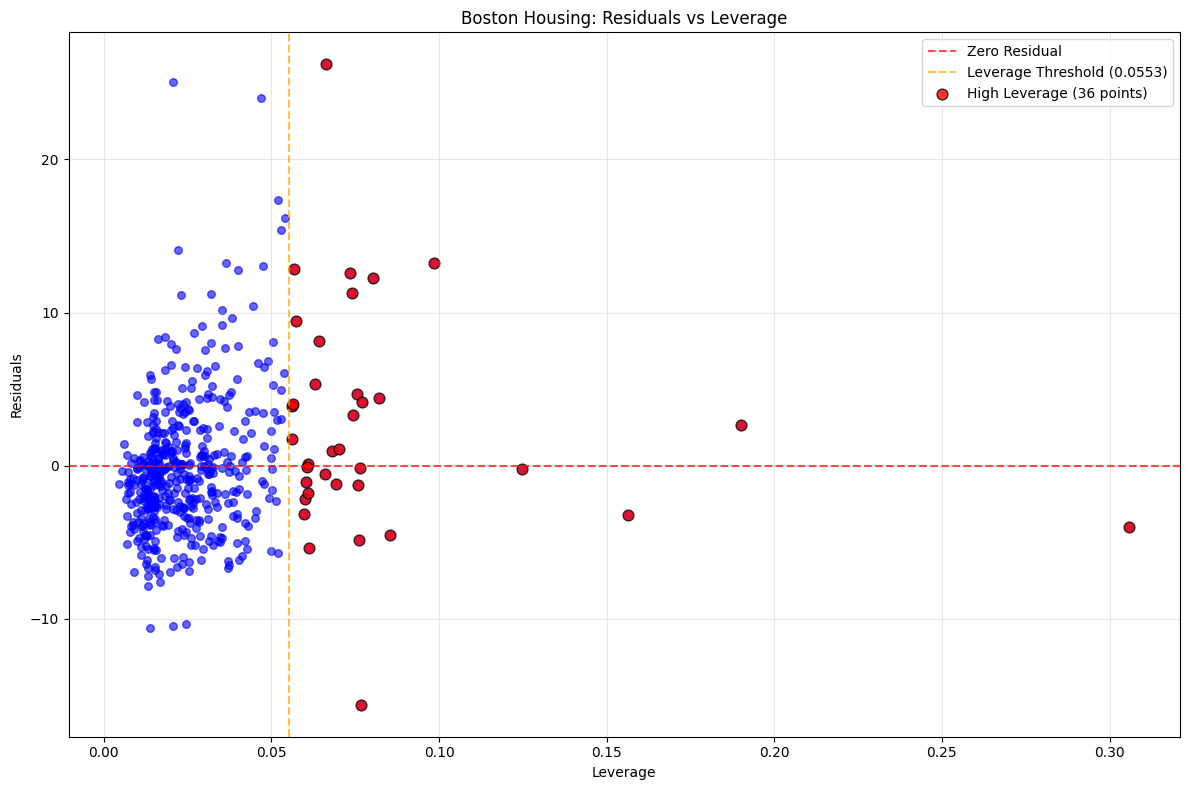

In [16]:
# Get influence measures for Boston housing
influence_boston = model_boston.get_influence()
leverage_boston = influence_boston.hat_matrix_diag
residuals_boston = model_boston.resid

# Calculate thresholds
n_boston = X_boston.shape[0]
p_boston = X_boston.shape[1] + 1  # including intercept
avg_lev_boston = p_boston / n_boston
threshold_boston = 2 * avg_lev_boston

print(f"Boston Housing Leverage Analysis:")
print(f"Sample size: {n_boston}")
print(f"Parameters: {p_boston}")
print(f"Average leverage: {avg_lev_boston:.6f}")
print(f"Threshold (2p/n): {threshold_boston:.6f}")

# Identify high leverage points
high_leverage_boston = np.where(leverage_boston > threshold_boston)[0]
print(f"\nHigh leverage points: {len(high_leverage_boston)}")
print(f"Percentage: {len(high_leverage_boston)/n_boston*100:.2f}%")
print(f"\nTop 5 highest leverage points:")
top_leverage_idx = np.argsort(leverage_boston)[-5:]
for i, idx in enumerate(reversed(top_leverage_idx)):
    print(f"{i+1}. Index {idx}: leverage = {leverage_boston[idx]:.6f}")

# Create leverage plot for Boston data
plt.figure(figsize=(12, 8))
plt.scatter(leverage_boston, residuals_boston, alpha=0.6, color='blue', s=30)
plt.axhline(0, color='red', linestyle='--', alpha=0.7, label='Zero Residual')
plt.axvline(threshold_boston, color='orange', linestyle='--', alpha=0.7, 
           label=f'Leverage Threshold ({threshold_boston:.4f})')

# Highlight high leverage points
if len(high_leverage_boston) > 0:
    plt.scatter(leverage_boston[high_leverage_boston], 
               residuals_boston[high_leverage_boston],
               color='red', s=60, alpha=0.8, 
               edgecolor='black', linewidth=1,
               label=f'High Leverage ({len(high_leverage_boston)} points)')

plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.title('Boston Housing: Residuals vs Leverage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3 Diamonds Dataset Analysis

In [17]:
# Load diamonds dataset
df_diamonds = sns.load_dataset('diamonds')

print("Diamonds Dataset:")
print(f"Shape: {df_diamonds.shape}")
display(df_diamonds.head())

# Use only numeric features for regression
X_diamonds = df_diamonds.drop(columns=['price']).select_dtypes(include=[np.number])
y_diamonds = df_diamonds['price']

print(f"\nNumeric features used: {list(X_diamonds.columns)}")
print(f"Sample size: {len(y_diamonds)}")

# Fit model (using subset for computational efficiency)
subset_size = 5000
subset_idx = np.random.choice(len(y_diamonds), subset_size, replace=False)
X_diamonds_subset = X_diamonds.iloc[subset_idx]
y_diamonds_subset = y_diamonds.iloc[subset_idx]

X_diamonds_const = sm.add_constant(X_diamonds_subset)
model_diamonds = sm.OLS(y_diamonds_subset, X_diamonds_const).fit()

print(f"\nDiamonds Regression (subset of {subset_size}):")
print(f"R-squared: {model_diamonds.rsquared:.4f}")

Diamonds Dataset:
Shape: (53940, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75



Numeric features used: ['carat', 'depth', 'table', 'x', 'y', 'z']
Sample size: 53940

Diamonds Regression (subset of 5000):
R-squared: 0.8607


### 6.4 Diamonds Dataset Leverage Summary

Diamonds Dataset Leverage Summary:
Threshold (2p/n): 0.002800
High leverage points: 315
Percentage: 6.30%


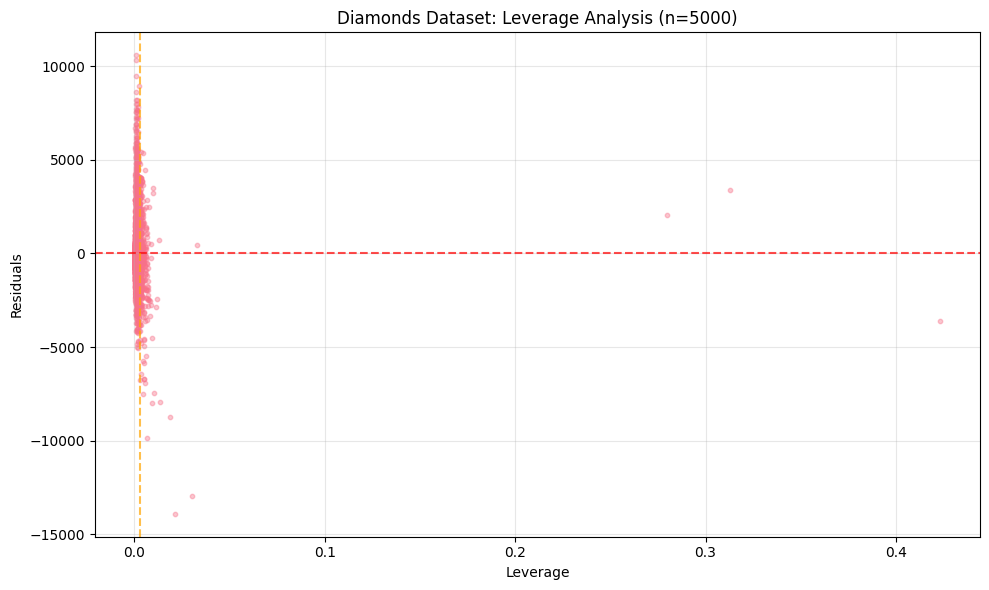

In [18]:
# Leverage analysis for diamonds (subset)
influence_diamonds = model_diamonds.get_influence()
leverage_diamonds = influence_diamonds.hat_matrix_diag
residuals_diamonds = model_diamonds.resid

n_diamonds = X_diamonds_subset.shape[0]
p_diamonds = X_diamonds_subset.shape[1] + 1
avg_lev_diamonds = p_diamonds / n_diamonds
threshold_diamonds = 2 * avg_lev_diamonds

high_leverage_diamonds = np.where(leverage_diamonds > threshold_diamonds)[0]

print(f"Diamonds Dataset Leverage Summary:")
print(f"Threshold (2p/n): {threshold_diamonds:.6f}")
print(f"High leverage points: {len(high_leverage_diamonds)}")
print(f"Percentage: {len(high_leverage_diamonds)/n_diamonds*100:.2f}%")

# Quick visualization
plt.figure(figsize=(10, 6))
plt.scatter(leverage_diamonds, residuals_diamonds, alpha=0.4, s=10)
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.axvline(threshold_diamonds, color='orange', linestyle='--', alpha=0.7)
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.title(f'Diamonds Dataset: Leverage Analysis (n={subset_size})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Summary and Interpretation

### 7.1 Key Findings and Recommendations

In [19]:
print("MULTIVARIATE ANALYSIS SUMMARY")
print("=" * 50)

print("\nDATASETS ANALYZED:")
datasets = [
    ("Synthetic Housing", n, p, len(high_leverage_2p)),
    ("Housing Market", n_houses, p_houses, len(high_leverage_houses)),
    ("Boston Housing", n_boston, p_boston, len(high_leverage_boston)),
    ("Diamonds (subset)", n_diamonds, p_diamonds, len(high_leverage_diamonds))
]

for name, n_obs, n_params, n_leverage in datasets:
    threshold = 2 * n_params / n_obs
    percentage = n_leverage / n_obs * 100
    print(f"{name:18}: n={n_obs:4}, p={n_params:2}, threshold={threshold:.4f}, high leverage={n_leverage:3} ({percentage:4.1f}%)")

print("\nKEY CONCEPTS:")
print("1. Hat Matrix: H = X(X'X)^(-1)X' projects y onto column space of X")
print("2. Leverage: h_ii = diagonal elements of hat matrix")
print("3. Average leverage: p/n (where p = number of parameters)")
print("4. High leverage threshold: typically 2p/n or 3p/n")
print("5. Leverage measures distance from center of X-space")

print("\nPRACTICAL IMPLICATIONS:")
print("- High leverage points have greater influence on fitted values")
print("- Leverage depends only on X values, not on y values")
print("- Points with high leverage deserve careful examination")
print("- Outliers in X-space may not be outliers in y-space")
print("- Covariance matrix reveals multivariate relationships")

print("\nRECOMMENDATIONS:")
print("- Always check for high leverage points in multivariate analysis")
print("- Use multiple thresholds (2p/n and 3p/n) for assessment")
print("- Combine leverage analysis with residual analysis")
print("- Consider robust regression methods when many outliers present")
print("- Examine correlation structure before model fitting")

MULTIVARIATE ANALYSIS SUMMARY

DATASETS ANALYZED:
Synthetic Housing : n= 500, p= 5, threshold=0.0200, high leverage= 15 ( 3.0%)
Housing Market    : n= 103, p= 2, threshold=0.0388, high leverage=  3 ( 2.9%)
Boston Housing    : n= 506, p=14, threshold=0.0553, high leverage= 36 ( 7.1%)
Diamonds (subset) : n=5000, p= 7, threshold=0.0028, high leverage=315 ( 6.3%)

KEY CONCEPTS:
1. Hat Matrix: H = X(X'X)^(-1)X' projects y onto column space of X
2. Leverage: h_ii = diagonal elements of hat matrix
3. Average leverage: p/n (where p = number of parameters)
4. High leverage threshold: typically 2p/n or 3p/n
5. Leverage measures distance from center of X-space

PRACTICAL IMPLICATIONS:
- High leverage points have greater influence on fitted values
- Leverage depends only on X values, not on y values
- Points with high leverage deserve careful examination
- Outliers in X-space may not be outliers in y-space
- Covariance matrix reveals multivariate relationships

RECOMMENDATIONS:
- Always check for 